In [ ]:
# mount the google drive folder
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

In [ ]:
pip install --quiet git+https://github.com/theislab/scgen.git

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import time
import scvi
import anndata
import pandas as pd
from scipy.io import mmread
from scipy.sparse import csr_matrix
import umap
import matplotlib.pyplot as plt
import os
import tempfile
import seaborn as sns
import torch
import scgen
import scib
import louvain

In [3]:
import warnings

sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

# Suppress specific ImportWarning
warnings.filterwarnings("ignore")

/Users/xiaoyushen/miniforge3/lib/python3.10/site-packages/scanpy/_settings.py:488: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)
/Users/xiaoyushen/miniforge3/lib/python3.10/tempfile.py:869: ResourceWarning: Implicitly cleaning up <TemporaryDirectory '/var/folders/6f/wd7m9z0d6wg__mwtlh6w4f7h0000gn/T/tmp_o_9bkip'>
  _warnings.warn(warn_message, ResourceWarning)


In [5]:
adata = anndata.read_h5ad("../Lung_two_species_raw.h5ad")
adata
# Assuming your AnnData object is named adata
adata.obs.rename(columns={'celltype': 'cell_type'}, inplace=True)
adata

AnnData object with n_obs × n_vars = 20760 × 62781
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'cell_type', 'species', 'batch', 'BATCH'
    var: 'genename-0', 'genename-1'

In [6]:
## Setting: randomly missing labels
np.random.seed(666)
total_cells = adata.n_obs

# Calculate the number of cells to label
num_labeled = int(0.5 * total_cells)

# Initialize all labels with NaN
semi_labels = pd.Series(np.nan, index=adata.obs.index)

# Randomly select 50% of the indices without replacement
indices = np.random.choice(adata.obs.index, size=num_labeled, replace=False)

# Assign the corresponding 'cell_type' labels to these selected indices
semi_labels.loc[indices] = adata.obs.loc[indices, 'cell_type']

# Now 'semi_labels' contains 30% known labels and 70% NaN
adata.obs['hard_label'] = semi_labels
#when the method requires fillna, ssSTACAS do not need this filling, but scANVI requires)
adata.obs['hard_label'].fillna("Unknown", inplace=True)
adata.obs['hard_label'] = adata.obs['hard_label'].astype('category')

In [9]:
# Save the new_labels column to a CSV file
adata.obs[['hard_label']].to_csv('../R_lung_two_species/labels/hard_label_lung_two_species_50.csv', index=True)

In [10]:
# Initialize the dictionary to store embeddings
embeddings_dict = {}

In [11]:
# preprocessing
adata.raw = adata
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=5)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key='batch')
adata = adata[:, adata.var['highly_variable']]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# scANVI

In [ ]:
# scVI
adata = adata.copy()
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

In [12]:
# Load the pretrained models
adata = adata.copy()
# Setup anndata with the same parameters used for training
scvi.model.SCVI.setup_anndata(adata, layer="counts", batch_key="batch")

# Load the trained model
model_path = "./model_scVI"
vae = scvi.model.SCVI.load(model_path, adata=adata)

adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.5)

INFO     File ./model_scVI/model.pt already downloaded                                                             


In [13]:
# Save embeddings
adata.obsm["X_scVI"] = adata.obsm["X_scVI"]

# Collect embeddings
embeddings_dict["X_scVI"] = adata.obsm["X_scVI"]

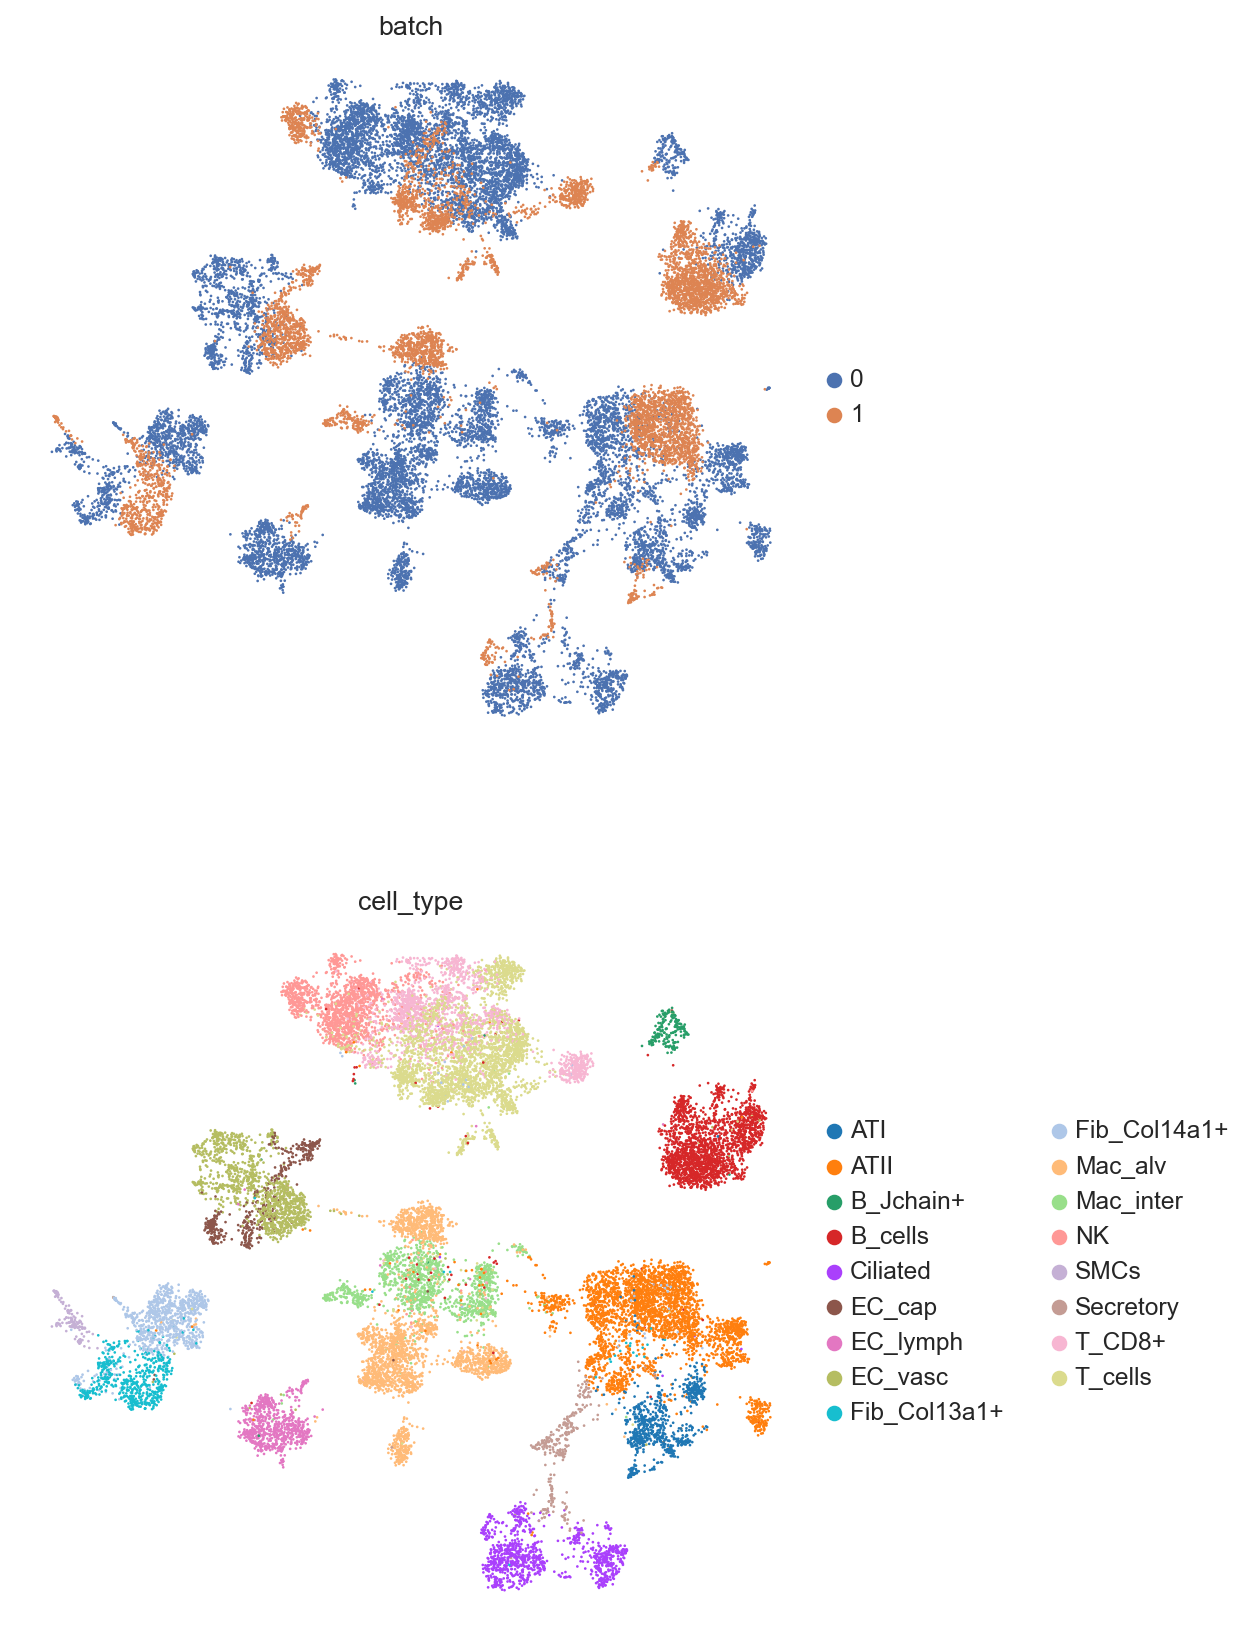

In [14]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

scANVI should be initialized from a scVI model pre-trained on the same exact data.

In [15]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="hard_label",
    unlabeled_category="Unknown",
)

In [16]:
scanvi_model.train(max_epochs=20, n_samples_per_label=100)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 20/20: 100%|█| 20/20 [01:23<00:00,  4.56s/it, v_num=1, train_loss_step=465

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|█| 20/20 [01:23<00:00,  4.17s/it, v_num=1, train_loss_step=465


In [17]:
SCANVI_LATENT_KEY = "X_scANVI"
SCANVI_PREDICTIONS_KEY = "C_scANVI"

adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)
adata.obs[SCANVI_PREDICTIONS_KEY] = scanvi_model.predict(adata)

In [18]:
# Save the embeddings
# Collect scANVI embeddings and predictions in the dictionary
embeddings_dict[SCANVI_LATENT_KEY] = adata.obsm[SCANVI_LATENT_KEY]
embeddings_dict[SCANVI_PREDICTIONS_KEY] = adata.obs[SCANVI_PREDICTIONS_KEY]

In [19]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)
sc.tl.umap(adata)

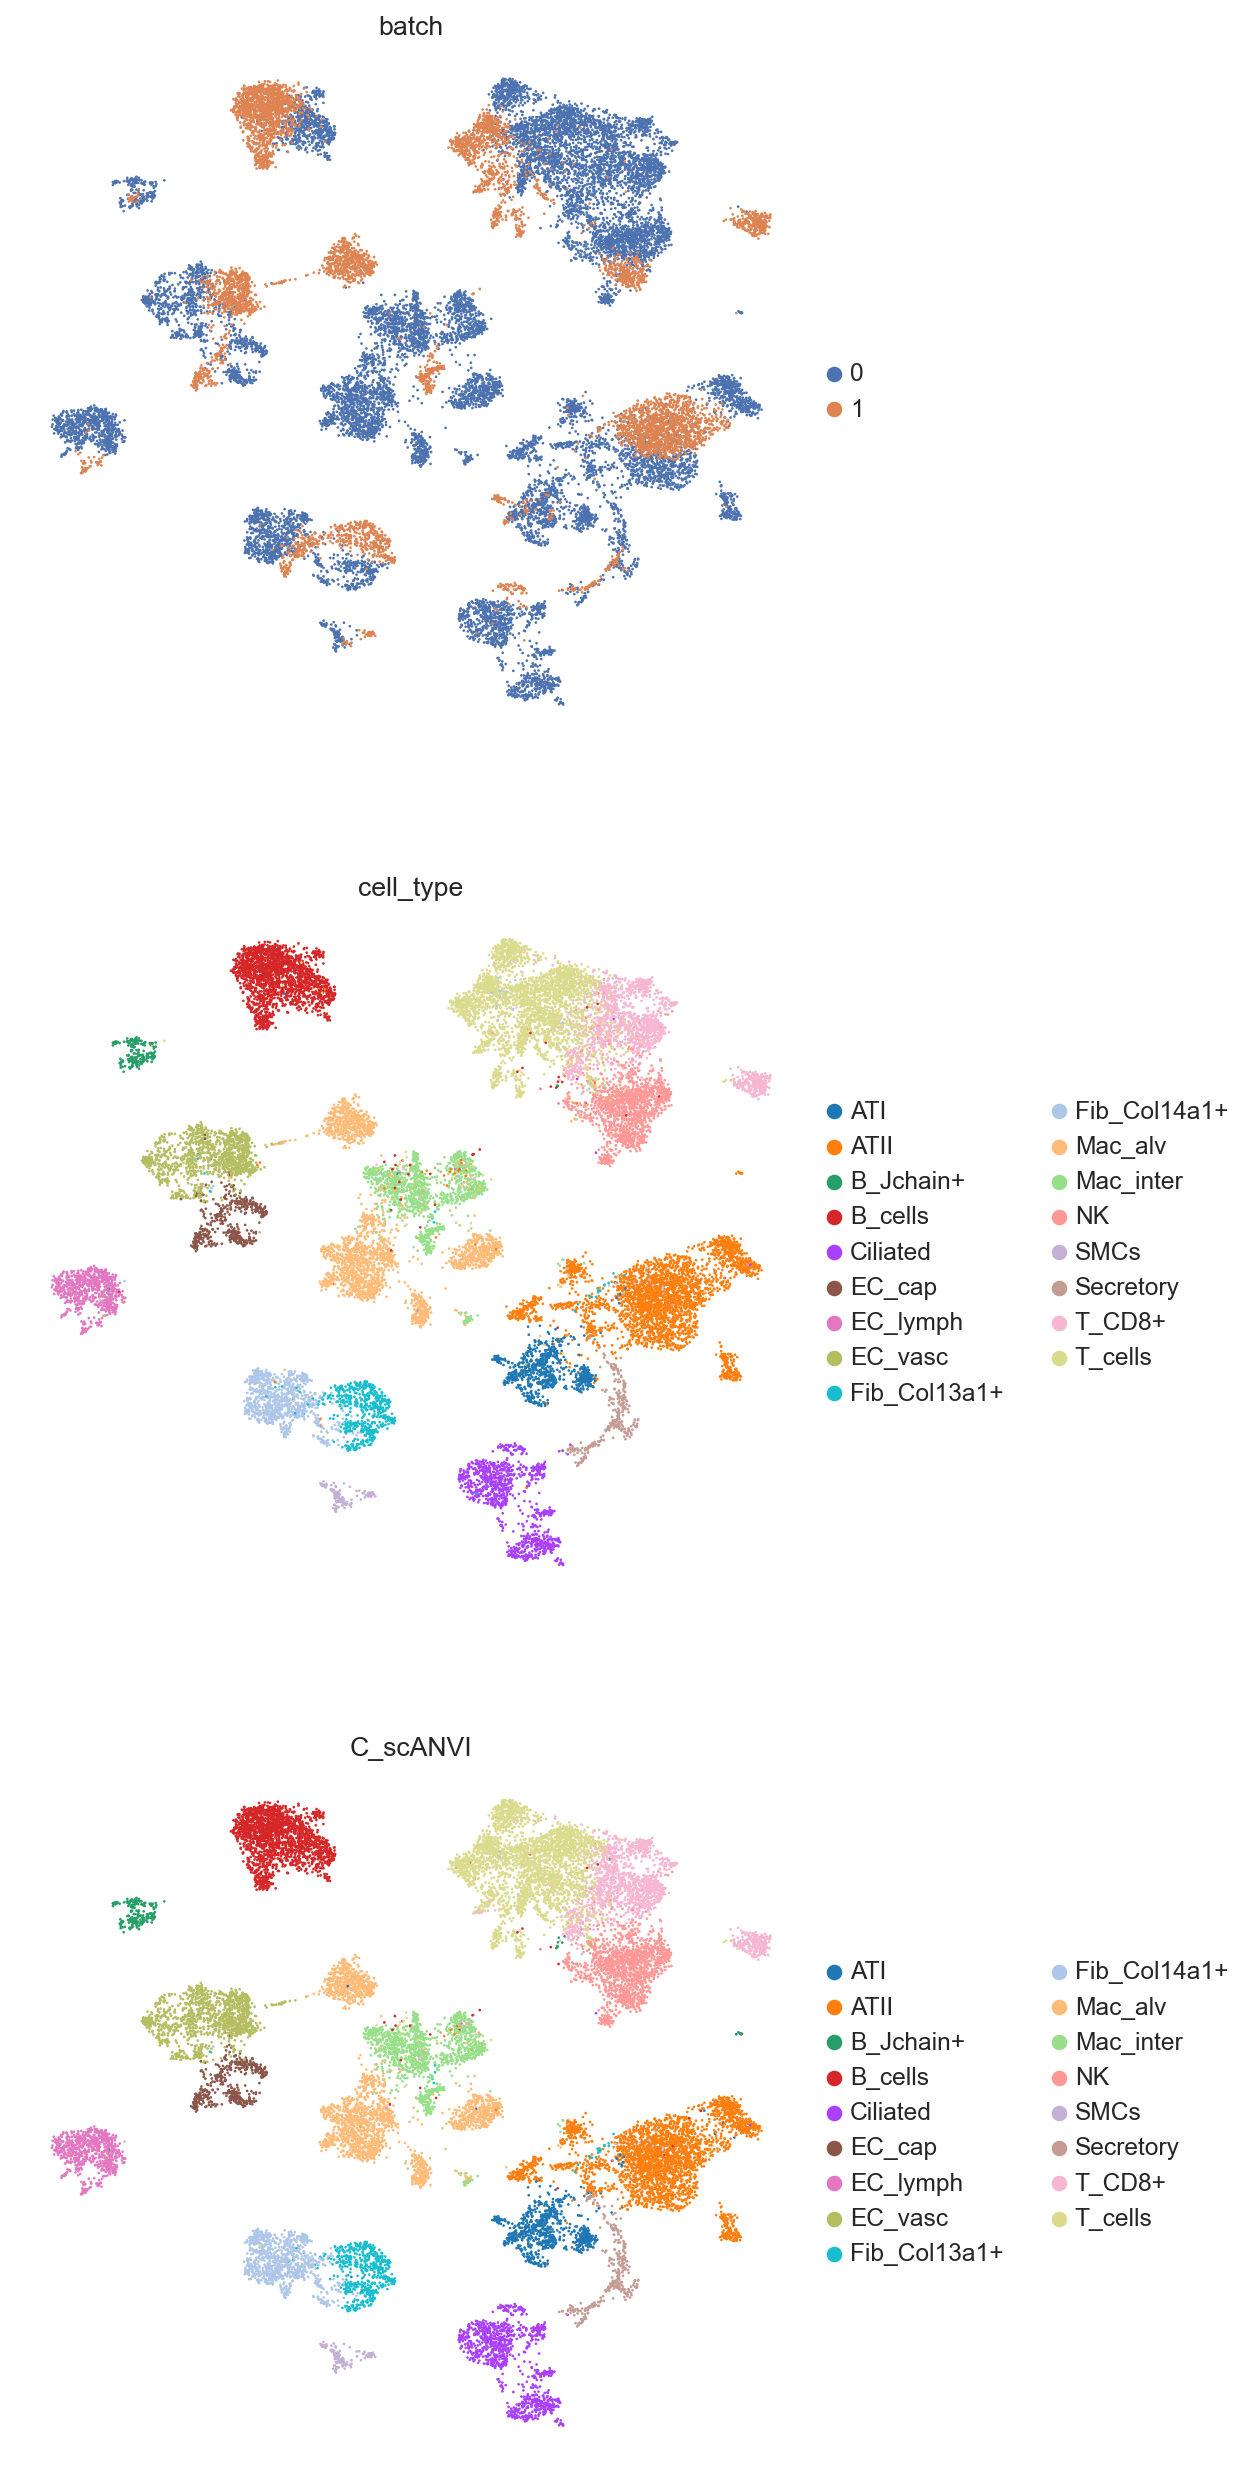

In [20]:
sc.pl.umap(adata, color=["batch", "cell_type", "C_scANVI"], frameon=False, ncols=1)

# scGEN

We need two observation labels "batch" and "cell_type" for our batch_removal procedure. There exist a "batch" obs but no "cell_type", so we add it as a .obs of adata (but we have cell_type in this datasets)

In [21]:
train = adata.copy()

### Preprocessing Data

In [22]:
scgen.SCGEN.setup_anndata(train, batch_key="batch", labels_key="hard_label")

## Creating and Training the model¶

In [23]:
model = scgen.SCGEN(train)

model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
)
# model.save("../saved_models/model_batch_removal.pt", overwrite=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 26/100:  26%|▎| 26/100 [04:04<11:34,  9.39s/it, v_num=1, train_loss_step=8
Monitored metric elbo_validation did not improve in the last 25 records. Best score: 735.869. Signaling Trainer to stop.


## Batch-Removal

In [24]:
corrected_adata = model.batch_removal()
corrected_adata

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


AnnData object with n_obs × n_vars = 20760 × 2000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sampleid', 'cellname', 'cell_type', 'species', 'batch', 'BATCH', 'hard_label', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'latent', 'corrected_latent'

In [25]:
# Save embeddings
corrected_adata.obsm["X_scgen"] = corrected_adata.obsm["latent"]

# Collect embeddings
embeddings_dict["X_scgen"] = corrected_adata.obsm["X_scgen"]

### Visualization of the corrected gene expression data¶

In [26]:
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

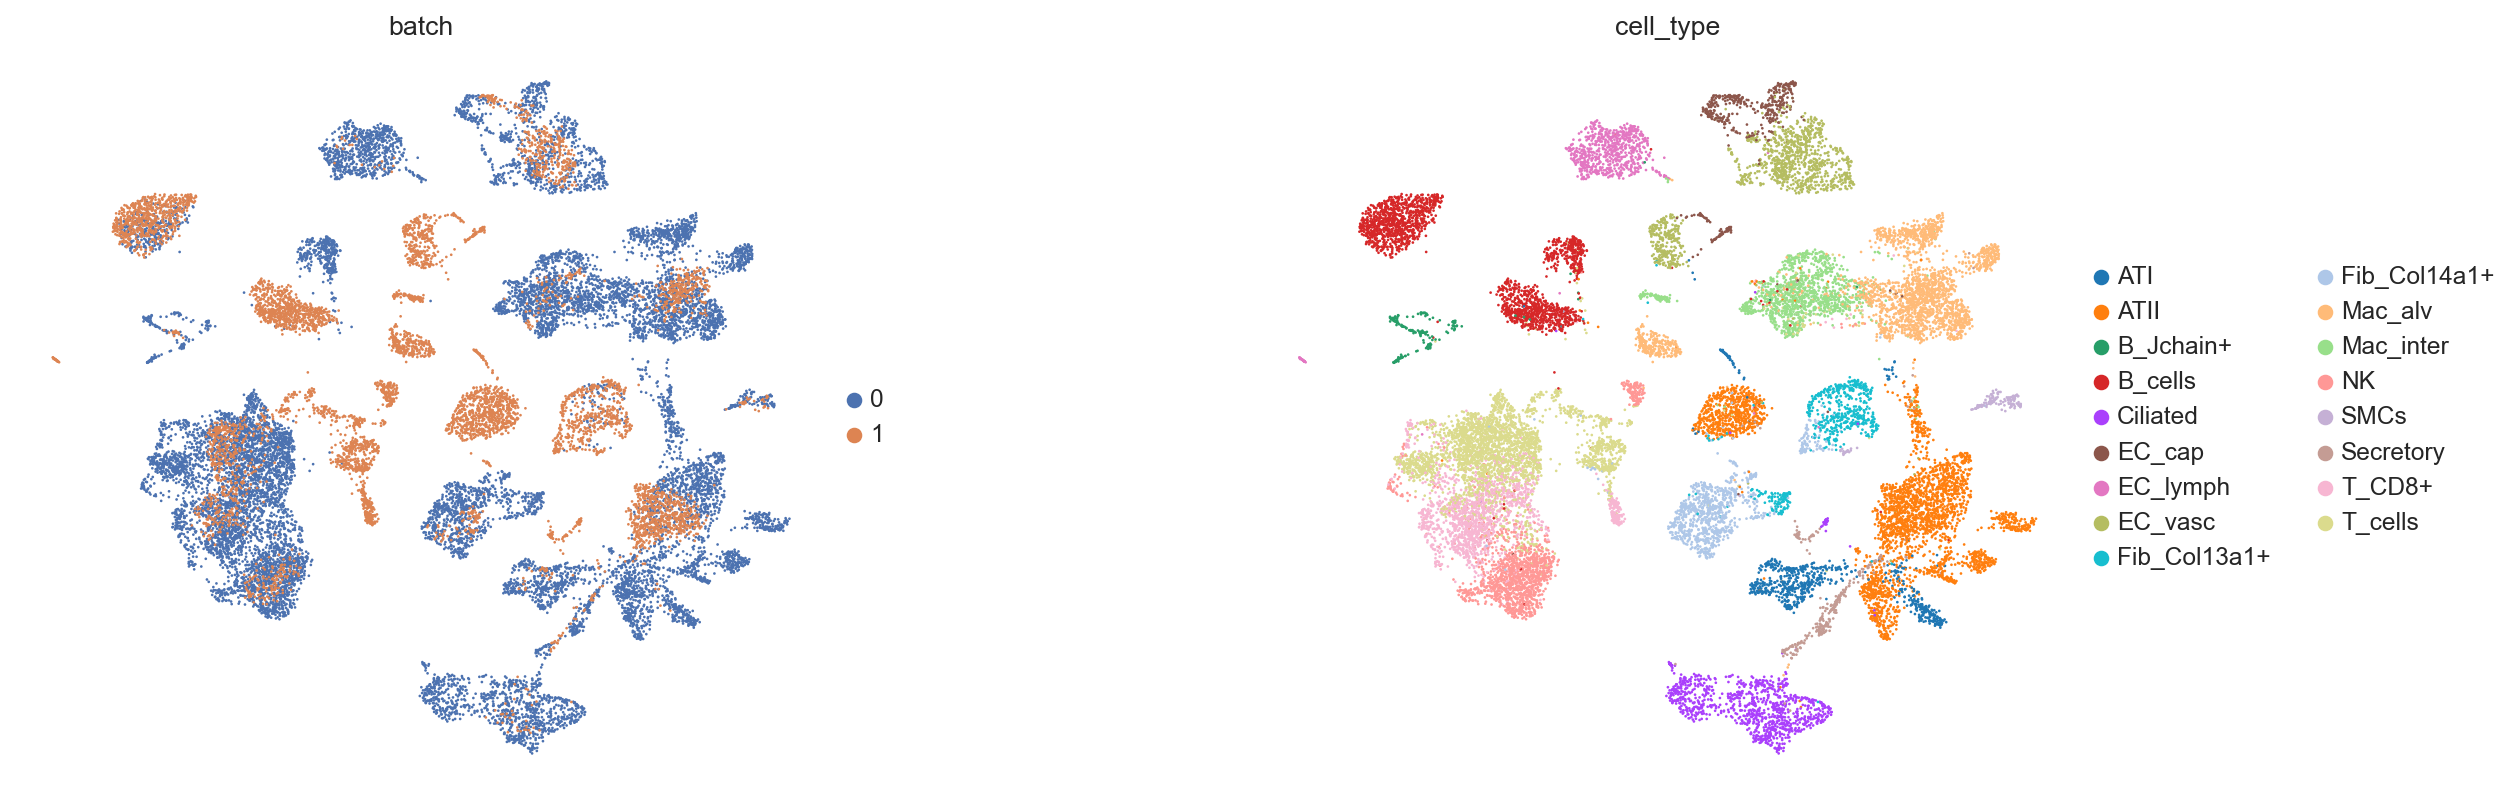

In [27]:
sc.pl.umap(corrected_adata, color=['batch', 'cell_type'], wspace=0.4, frameon=False)

# STACAS

Semi-supervised integration results

In [28]:
pca_embeddings = pd.read_csv('../R_lung_two_species/embeddings/lung_two_species_stacas_embeddings_randomly_missing_labels_50.csv', index_col=0)
adata.obsm['X_stacas'] = pca_embeddings.values
sc.pp.neighbors(adata, use_rep="X_stacas")
sc.tl.umap(adata, min_dist=0.5)

In [29]:
# Collect embeddings
embeddings_dict["X_stacas"] = pca_embeddings.values

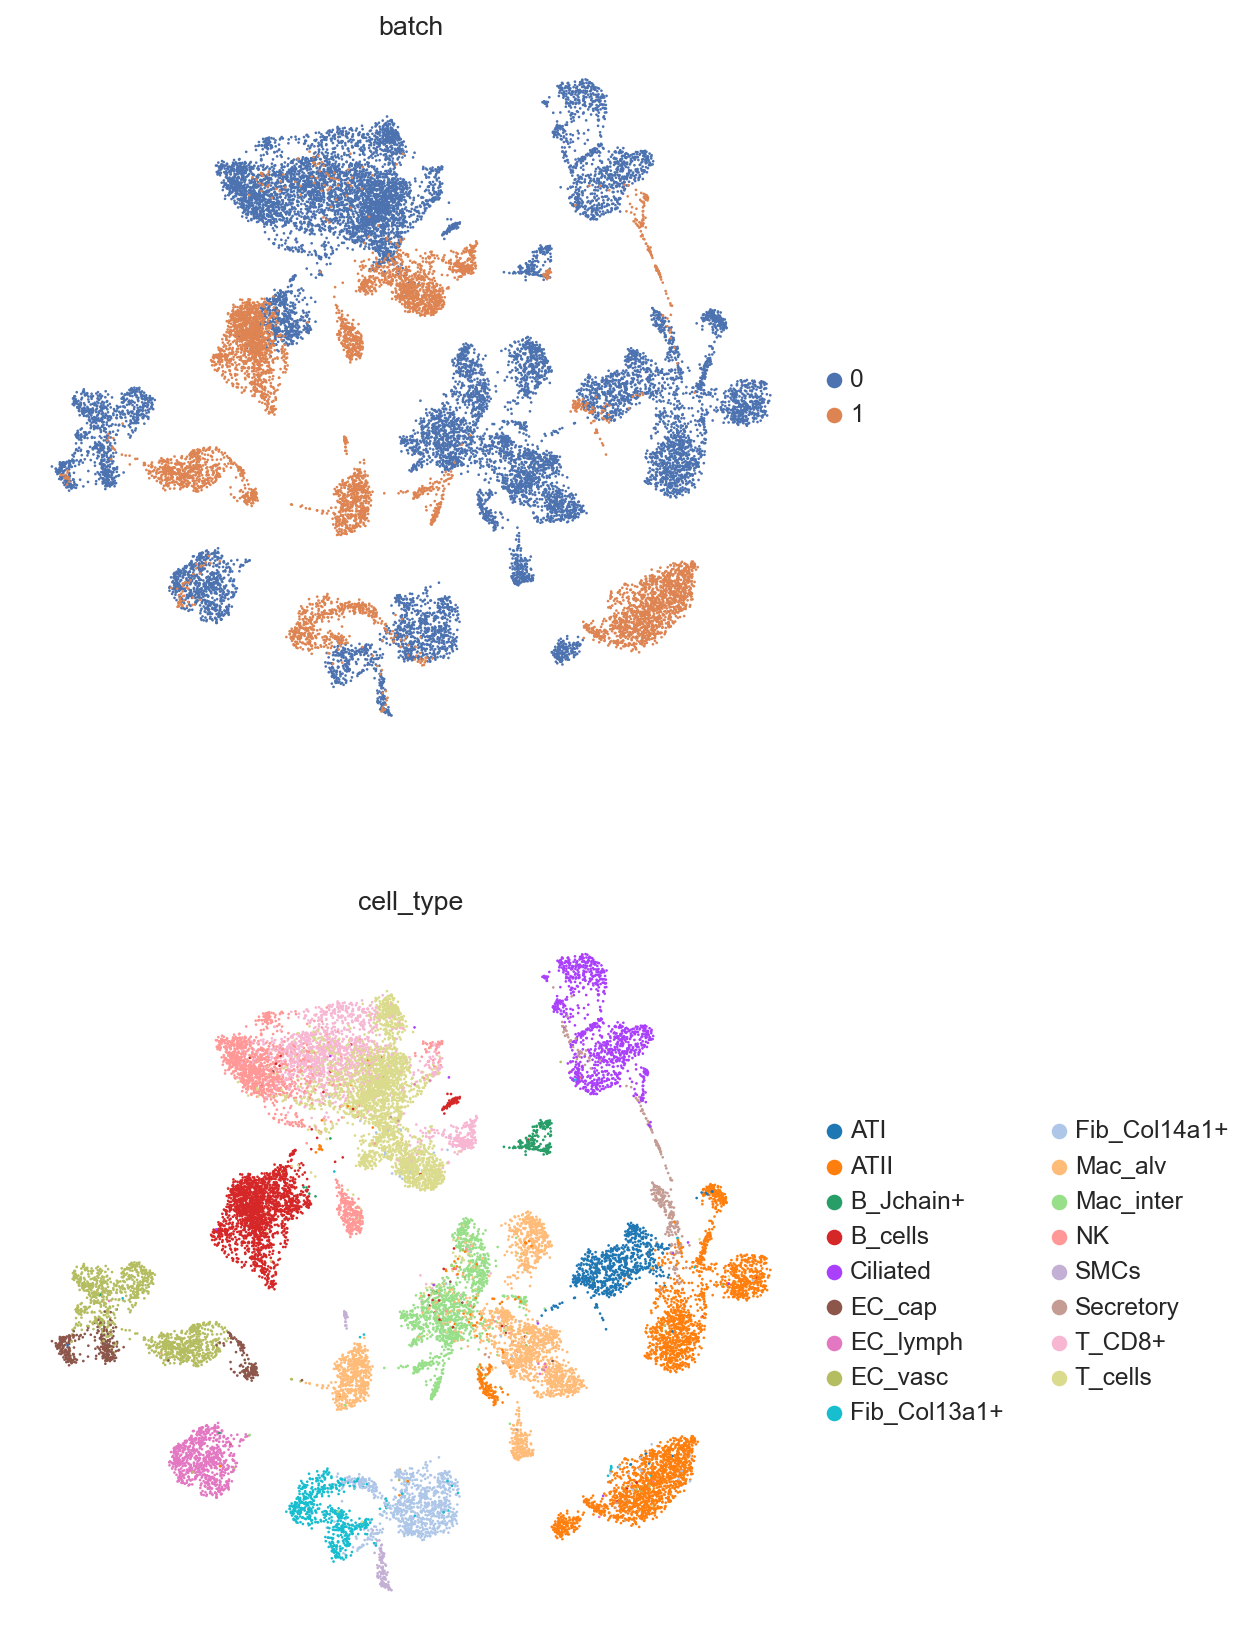

In [30]:
sc.pl.umap(adata, color=["batch", "cell_type"], frameon=False, ncols=1)

In [32]:
# save all the embeddings
# Concatenate embeddings and save to CSV
combined_embeddings = pd.concat(
    {key: pd.DataFrame(value, index=adata.obs_names) for key, value in embeddings_dict.items()},
    axis=1
)
combined_embeddings.to_csv("../embeddings/randomly_missing_lung_two_species_50.csv")


# Metric Evaluation

## read the embeddings

In [33]:
# Step 1: Read the CSV file into a DataFrame
combined_embeddings = pd.read_csv("../embeddings/randomly_missing_lung_two_species_50.csv", index_col=0)

# Step 2: Ensure indices match
combined_embeddings = combined_embeddings.loc[adata.obs_names]

# Step 3: Split the DataFrame into separate DataFrames for each embedding
embedding_keys = ["X_scANVI", "X_scgen", "X_stacas"]
embeddings_dict = {key: combined_embeddings.filter(like=key) for key in embedding_keys}

# Step 4: Assign the embeddings back to adata.obsm
for key, df in embeddings_dict.items():
    adata.obsm[key] = df.values

# Now `adata.obsm` contains the loaded embeddings

In [35]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df1_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scANVI')

resolution: 0.1, nmi: 0.8251499264958828
resolution: 0.2, nmi: 0.8491430619825345
resolution: 0.3, nmi: 0.842756899288379
resolution: 0.4, nmi: 0.8205744917667918
resolution: 0.5, nmi: 0.8294710937852053
resolution: 0.6, nmi: 0.8376687672562435
resolution: 0.7, nmi: 0.8259427267580618
resolution: 0.8, nmi: 0.8175628047453973
resolution: 0.9, nmi: 0.8118830615535805
resolution: 1.0, nmi: 0.8114726067130925
resolution: 1.1, nmi: 0.7932154899807217
resolution: 1.2, nmi: 0.787662502951589
resolution: 1.3, nmi: 0.7870725435172967
resolution: 1.4, nmi: 0.7817771668464532
resolution: 1.5, nmi: 0.7880534290203953
resolution: 1.6, nmi: 0.785363476825886
resolution: 1.7, nmi: 0.7692468162521447
resolution: 1.8, nmi: 0.7662278742024132
resolution: 1.9, nmi: 0.7606843128816084
resolution: 2.0, nmi: 0.754495440878317
optimised clustering against cell_type
optimal cluster resolution: 0.2
optimal score: 0.8491430619825345
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on re

In [36]:
sc.pp.neighbors(adata, use_rep="X_scgen")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df2_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_scgen')

resolution: 0.1, nmi: 0.7417329550525931
resolution: 0.2, nmi: 0.7643565837546288
resolution: 0.3, nmi: 0.7469167963114347
resolution: 0.4, nmi: 0.7803284562548704
resolution: 0.5, nmi: 0.7731374176704155
resolution: 0.6, nmi: 0.778740440840033
resolution: 0.7, nmi: 0.7778301288158467
resolution: 0.8, nmi: 0.7783943732709577
resolution: 0.9, nmi: 0.7754109564731752
resolution: 1.0, nmi: 0.7675194351016061
resolution: 1.1, nmi: 0.7677302600071515
resolution: 1.2, nmi: 0.7676210569927009
resolution: 1.3, nmi: 0.7686828797664419
resolution: 1.4, nmi: 0.7639455885376448
resolution: 1.5, nmi: 0.7594298791930193
resolution: 1.6, nmi: 0.7613463794088277
resolution: 1.7, nmi: 0.7493535512641598
resolution: 1.8, nmi: 0.750212626903954
resolution: 1.9, nmi: 0.7422390544615223
resolution: 2.0, nmi: 0.736908091057205
optimised clustering against cell_type
optimal cluster resolution: 0.4
optimal score: 0.7803284562548704
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on r

In [37]:
sc.pp.neighbors(adata, use_rep="X_stacas")
scib.me.cluster_optimal_resolution(adata, cluster_key="cluster", label_key="cell_type")
df3_1 = scib.me.metrics(adata, adata_int=adata, silhouette_=True, graph_conn_=True, ari_=True, nmi_= True, isolated_labels_=True, isolated_labels_f1_=True, isolated_labels_asw_=True,  batch_key='batch', label_key = 'cell_type', embed = 'X_stacas')

resolution: 0.1, nmi: 0.7841099827867328
resolution: 0.2, nmi: 0.7620373983204917
resolution: 0.3, nmi: 0.7624463231022705
resolution: 0.4, nmi: 0.7729513804872623
resolution: 0.5, nmi: 0.7630496424168253
resolution: 0.6, nmi: 0.7639291944487553
resolution: 0.7, nmi: 0.7619767075182794
resolution: 0.8, nmi: 0.7546802039343321
resolution: 0.9, nmi: 0.7492150077143778
resolution: 1.0, nmi: 0.7467828057018718
resolution: 1.1, nmi: 0.7475342414539387
resolution: 1.2, nmi: 0.748100524491797
resolution: 1.3, nmi: 0.7460804722066752
resolution: 1.4, nmi: 0.7398987993105166
resolution: 1.5, nmi: 0.7380696856965275
resolution: 1.6, nmi: 0.7411503979652385
resolution: 1.7, nmi: 0.7373863727193403
resolution: 1.8, nmi: 0.7400287128172658
resolution: 1.9, nmi: 0.7354364769303309
resolution: 2.0, nmi: 0.7334766977702062
optimised clustering against cell_type
optimal cluster resolution: 0.1
optimal score: 0.7841099827867328
NMI...
ARI...
Silhouette score...
Isolated labels F1...
Compute neighbors on

In [38]:
# Adding new columns to each dataframe
df1_1['scANVI'] = df1_1.iloc[:, 0]
df2_1['scGEN'] = df2_1.iloc[:, 0]
df3_1['STACAS'] = df3_1.iloc[:, 0]

# Selecting only the new columns to avoid duplicate data
df1_1 = df1_1[['scANVI']]
df2_1 = df2_1[['scGEN']]
df3_1 = df3_1[['STACAS']]

# Merging the dataframes along the columns
merged_df = pd.concat([df1_1, df2_1, df3_1], axis=1)

merged_df.to_csv("../metrics/lung_two_species_metrics_randomly_missing_50.csv", index=True)

In [39]:
merged_df

,scANVI,scGEN,STACAS
NMI_cluster/label,0.845687,0.780384,0.788507
ARI_cluster/label,0.731850,0.588858,0.569432
ASW_label,0.630660,0.578378,0.617066
ASW_label/batch,0.848662,0.862582,0.769606
PCR_batch,NaN,NaN,NaN
cell_cycle_conservation,NaN,NaN,NaN
isolated_label_F1,0.929923,0.852578,0.821191
isolated_label_silhouette,0.636064,0.579546,0.621989
graph_conn,0.990171,0.976346,0.983872
kBET,NaN,NaN,NaN
